In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import binom
from scipy.stats import beta
import re
from scipy.optimize import minimize

In [ ]:
# The following is a simple example of how to use the ELBO function basing on https://rstudio-pubs-static.s3.amazonaws.com/630126_c2063706da044eb6a2944d7027dcce4d.html
# There is open source code for the ELBO function using python at https://pyro.ai/examples/svi_part_i.html

In [3]:
def log_likelihood(x,z):
    # x is a vector of observed data
    # z is a vector of latent variables
    # returns the log likelihood of the data given the latent variables
    # in this case, the log likelihood is the log probability mass function of a binomial distribution
    # The pruned binomial distribution is used to avoid numerical issues

    val = binom.logpmf(x, 1, z)
    val[np.isinf(val) & (val < 0)] = -10000
    val[np.isinf(val) & (val > 0)] = 10000
    return val

In [4]:
def log_prior(z):
    # z is a vector of latent variables
    # returns the log prior of the latent variables
    # in this case, the log prior is the log probability density function of a beta distribution
    # The pruned beta distribution is used to avoid numerical issues
    # The initial values of the beta distribution are set to 10,10
    val = beta.logpdf(z, a=10, b=10)
    val[np.isinf(val) & (val < 0)] = -10000
    val[np.isinf(val) & (val > 0)] = 10000
    return val

In [21]:
def log_variational(z, phi):
    # z is a vector of latent variables
    # phi is a vector of variational parameters
    # returns the log variational distribution of the latent variables
    # in this case, the log variational distribution is the log probability density function of a beta distribution
    # The pruned beta distribution is used to avoid numerical issues
    val = beta.logpdf(z, a=phi[0], b=phi[1])
    val[np.isinf(val) & (val < 0)] = -10000
    val[np.isinf(val) & (val > 0)] = 10000
    return val

In [24]:
## FIXME:: We can vectorize this functiont to speed up the process

def ELBO(phi, x, n_samples=10000):
    # phi is a vector of variational parameters
    # x is a vector of observed data
    # n_samples is the number of samples used to approximate the expectation
    # returns the simulated ELBO value
    np.random.seed(20230125)
    sum = 0
    for i in range(n_samples):
        # simulates z
        z = beta.rvs(a=phi[0], b=phi[1], size=1)

        # sum of log likelihoods
        sum_log_lik = np.sum(log_likelihood(x, z))

        # log prior
        log_pr = log_prior(z)

        # log variational
        log_var = log_variational(z, phi)
        sum += sum_log_lik + log_pr - log_var

    # average (approximates expectation)
    return sum / n_samples
def neg_ELBO(phi, x, n_samples=10000):
    # phi is a vector of variational parameters
    # x is a vector of observed data
    # n_samples is the number of samples used to approximate the expectation
    # returns the negative ELBO value
    return -ELBO(phi, x, n_samples)

In [25]:
def optim_ELBO(phi0, x_sample, n_samples):
    # fnscale -1 is used for specifying a maximization problem
    bounds = [(0.00001, 100), (0.00001, 100)]
    result = minimize(neg_ELBO, phi0, args=(x_sample, n_samples), bounds=bounds, method='L-BFGS-B')
    return result

In [45]:
def plot_posterior(phi_opt, true_prob, n_tos,plot_ax):
    x = np.linspace(0, 1, 100)
    y = beta.pdf(x, a=phi_opt[0], b=phi_opt[1])
    plot_ax.plot(x, y, 'r-', lw=2, label='Posterior')
    plot_ax.axvline(true_prob, color='blue', lw=1.6, label='True Probability')
    plot_ax.set_xlabel('z')
    plot_ax.set_ylabel('q(z)')
    plot_ax.set_title(f'With {n_tos} tosses')
    plot_ax.legend()

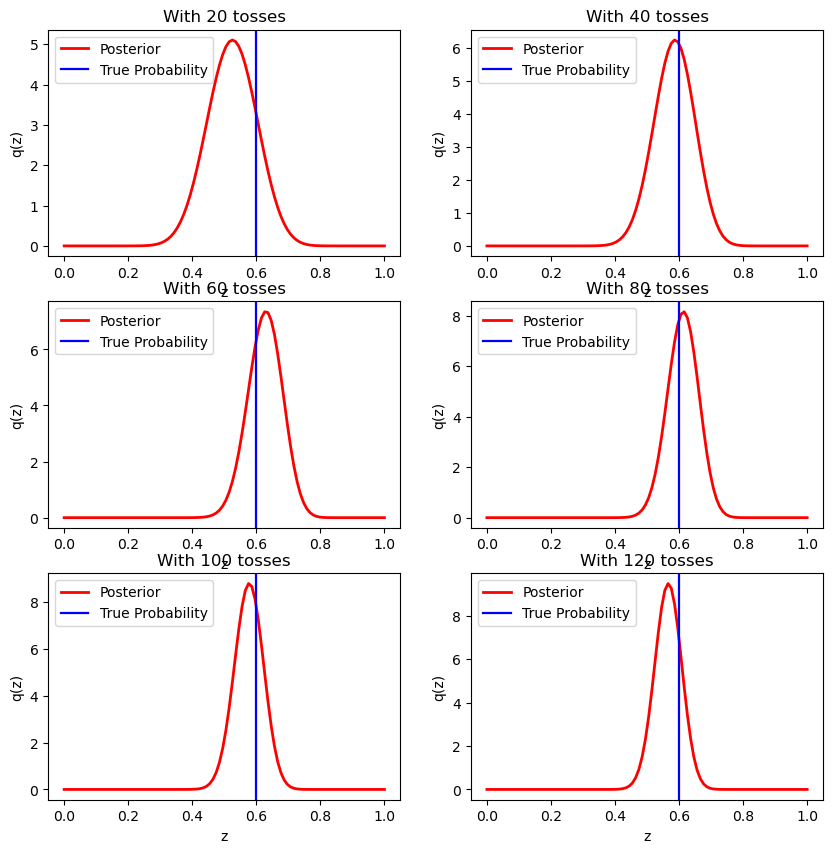

In [53]:

#True probability of heads
true_prob = 0.6

#Initial values for alpha and beta
phi0 = [8, 5]

#Number of samples from 
#the variational distribution
n_samples = 2000

#Number of tosses
n_tos = 100

fig, axs = plt.subplots(3, 2, figsize=(10, 10))
axs = axs.ravel()
to_plot = []
for i, ax in zip(range(20, 140, 20), axs):
    x_sample = np.random.binomial(1, true_prob, size=i)

    phi_opt = optim_ELBO(phi0, x_sample, n_samples)

    plot_posterior(phi_opt.x, true_prob, i, ax)
plt.show()



